In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette('Set1'))

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 16,'axes.titlesize':18,'axes.labelsize':18,'xtick.labelsize':16,\
                    'ytick.labelsize':16,'legend.fontsize':16,'legend.title_fontsize':16})

Direct binary classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for DecisionTree and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AVERAGE PRECISION
6. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AREA UNDER ROC CURVE
7. Precision-recall curve with best preprocessing and parameters for PRECISION
8. ROC curve with best preprocessing and parameters for AREA UNDER ROC CURVE
9. Use curves to determine if precision can be increased and FPR can be reduced
10. Produce confusion matrix with best parameters for precision or area under ROC curve (whichever gave best CV score)
11. Shift decision threshold to improve precision and FPR - reducing instances where resistant cases are predicted to be susceptible

1. Seperate the dataframe into a features and label dataset 

In [3]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations
- Also have a smaller test set to be used for cross-validaiton which comes from the training set

In [4]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [5]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [6]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size=0.2)

3. Establish pipeline and parameter grid for DecisionTree and grid search

In [8]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[2,4,6,8,10,12,14, None], 
              'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
              'max_features':['auto','sqrt','log2', None]}

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [9]:
#Grid search with shuffled kfold validation for accuracy
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6491628614916285
grid_kfold_shuffle: test set average accuracy:  0.7802197802197802 



In [10]:
from matplotlib import pyplot as plt
import numpy as np

#define trees with best perfoming parameters, or default parameters
tree_best_params = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1,
                       min_samples_split=0.1, random_state=0)
tree_no_params = DecisionTreeClassifier(random_state=0)
tree_best_params.fit(X_train_cv, y_train_cv)    
tree_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('Feature importance plot')

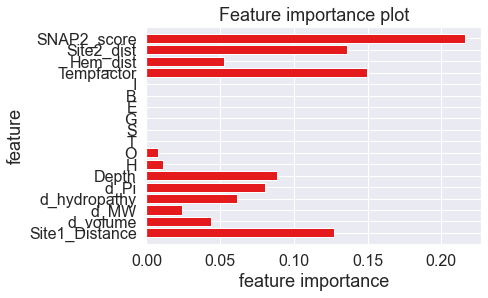

In [11]:
plot_feature_importances(tree_no_params)

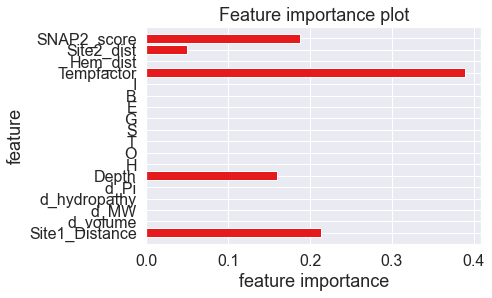

In [12]:
plot_feature_importances(tree_best_params)

5. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AVERAGE PRECISION

In [13]:
#Grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6261738916988926
grid_kfold_shuffle test set average precision:  0.7303949017747683 



6. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AREA UNDER ROC CURVE

In [14]:
#Grid search with shuffled kfold validation
#use predict_proba function to calculate AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6774354729617886
grid_kfold_shuffle test set AUC:  0.7557971014492754 



7. Precision-recall curve with best preprocessing and parameters for PRECISION

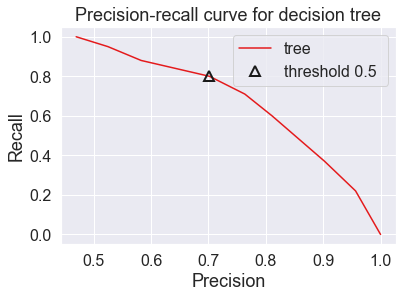

In [15]:
#use best parameters for average precision

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)

precision, recall, thresholds = precision_recall_curve(y_test_nodup, tree.predict_proba(X_test_nodup)[:, 1])

plt.plot(precision, recall, label='tree')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve for decision tree')
plt.legend(loc='best')
plt.savefig('figures/PR_curve_DT.png', bbox_inches='tight')

8. ROC
curve with best preprocessing and parameters for AREA UNDER ROC CURVE

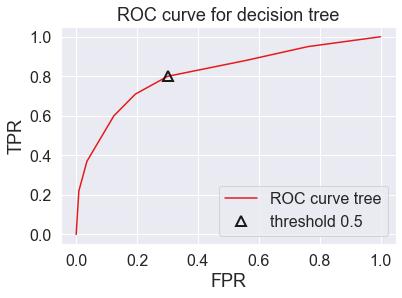

In [16]:
# use best parameters for AUC
from sklearn.metrics import roc_curve

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)

fpr, tpr, thresholds = roc_curve(y_test_nodup, tree.predict_proba(X_test_nodup)[:, 1])

plt.plot(fpr, tpr, label='ROC curve tree')
plt.xlabel('FPR')
plt.ylabel('TPR')

close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.title('ROC curve for decision tree')
plt.legend(loc=4)
plt.savefig('figures/ROC_curve_DT.png', bbox_inches='tight')

9. Use curves to determine if precision can be increased and FPR can be reduced 

- Both could be shifted with a relatively even cost

10. Produce confusion matrix with best parameters for precision or area under ROC curve (whichever gave best CV score)

In [17]:
#confusion matrix (max_features=auto, max_depth=4, min_samples_leaf=0.1, min_samples_split = 0.1)   
   
from sklearn.metrics import confusion_matrix

#build and fit decision tree
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)
predict = tree.predict(X_test_nodup).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

#calculate precision, sensitivty, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

# begins creates list for model comparison:
direct_VME = very_major_error
direct_ME = major_error

Precision:  0.7634408602150538
Sensitivity:  0.71
Specificity:  0.8053097345132744
FPR : 0.19469026548672563
very major error : 19.469026548672566
major error:  28.999999999999996

 confusion matrix: 
 [[91 22]
 [29 71]]


{0: 120, 1: 93}


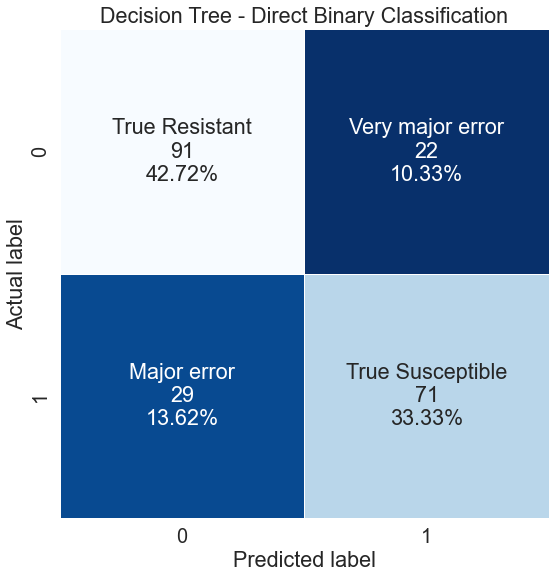

In [18]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
sns.set(font_scale=1.8)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Decision Tree - Direct Binary Classification');
plt.savefig('figures/direct_unshifted_matrix_DT.png', bbox_inches='tight')

11. Shift decision threshold to improve precision and FPR - reducing instances where resistant cases are predicted to be susceptible

C:\Users\user\AppData\Local\Temp/ipykernel_27456/1802971156.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_27456/1802971156.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_27456/1802971156.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_27456/1802971156.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_27456/1802971156.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))


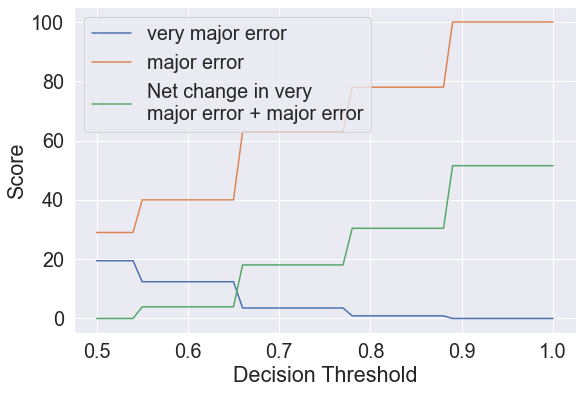

Shifting does not improve results


<Figure size 432x288 with 0 Axes>

In [19]:
# graph showing how major and very major error changes with decision threshold

threshold  = np.linspace(0.5,1,num = 51)
very_major_error = []
major_error = []
net_error_change = []
threshold_shift = []

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)
predicted_proba = tree.predict_proba(X_test_nodup)

predict = (predicted_proba[:,1] >= 0.5).astype('int')
confusion = confusion_matrix(y_test_nodup, predict)
og_very_major_error = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
og_major_error = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

for i in threshold:
    predict = (predicted_proba[:,1] >= i).astype('int')
    confusion = confusion_matrix(y_test_nodup, predict)
    very_major_error.append((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
    major_error.append((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

    #code to mathematically determine optimum threshold shifting
    vm_error_cost = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100) - og_very_major_error
    m_error_cost = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100) - og_major_error
    net_error_change.append(m_error_cost + vm_error_cost)
    grad_change = (m_error_cost / (-1*vm_error_cost))
    if grad_change <= 1.5:
        threshold_shift.append(i)

plt.figure(figsize=(9, 6))   
plt.plot(threshold, very_major_error, label = 'very major error')
plt.plot(threshold, major_error, label = 'major error')
plt.plot(threshold, net_error_change, label = 'Net change in very\nmajor error + major error')

plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend()
plt.show()
plt.savefig('figures/decision_curve_DT.png', bbox_inches='tight')

if threshold_shift == []:
    optimum_thresh = 0.5
    print('Shifting does not improve results')
else:
    optimum_thresh = max(threshold_shift)
    print('Optimum threshold to reduce very major error without \
    increasing major error by more than 1.5x :\n'\
        ,max(threshold_shift))

In [20]:
# shift threshold accoriding to data above - optimum theshold to decrease FPR without
# increasing major error by more than 1.5 x
# = no shift

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)
predicted_proba = tree.predict_proba(X_test_nodup)
predict = (predicted_proba[:,1] >= optimum_thresh).astype('int')
confusion = confusion_matrix(y_test_nodup, predict)

Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)

print ('\n confusion_matrix: \n', confusion)

# adds to list for model quality comparison
shifted_direct_VME = very_major_error
shifted_direct_ME = major_error

Precision:  0.7634408602150538
Sensitivity:  0.71
Specificity:  0.8053097345132744
FPR : 0.19469026548672563
very major error : 19.469026548672566
major error:  28.999999999999996

 confusion_matrix: 
 [[91 22]
 [29 71]]


{0: 120, 1: 93}


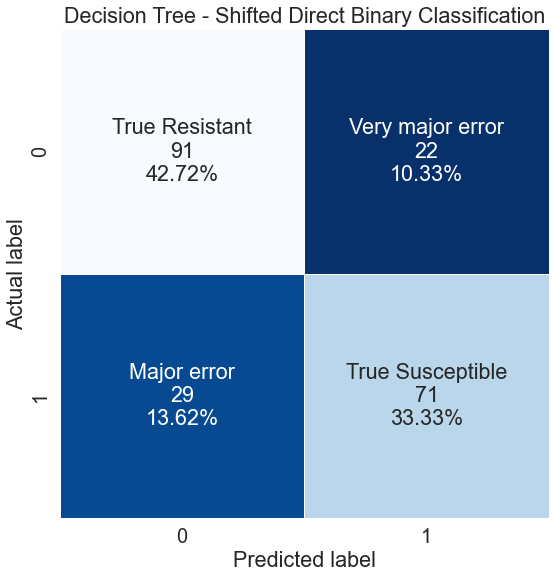

In [21]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Decision Tree - Shifted Direct Binary Classification');
plt.savefig('figures/direct_shifted_matrix_DT.png', bbox_inches='tight')

Optimum model: DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)

Feature importance data for model comparison:

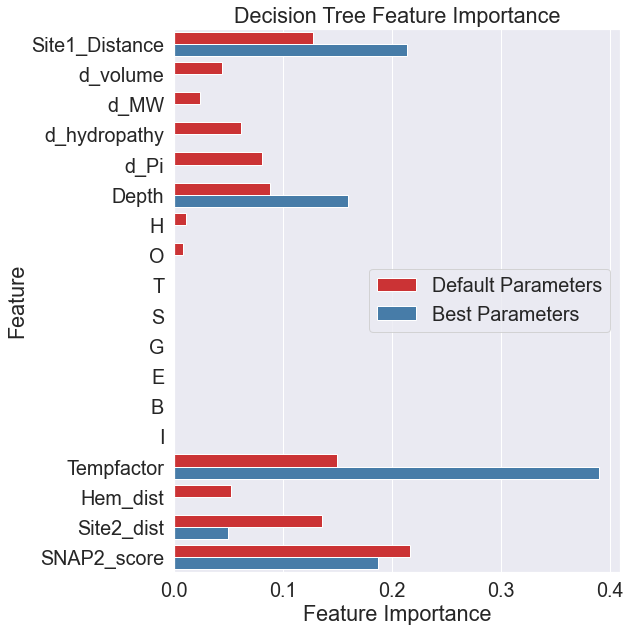

In [22]:
no_params = DecisionTreeClassifier(random_state=0)

best_params = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)

no_params.fit(X_train_cv, y_train_cv)
best_params.fit(X_train_cv, y_train_cv)

DF = pd.DataFrame({'Default Parameters':(no_params.feature_importances_),
                   'Best Parameters':(best_params.feature_importances_),
                   'n_features':np.arange(X_train_cv.shape[1])})
                          
df_melted = DF.melt("n_features",var_name="Params",value_name="importance")

sns.set_theme()
sns.set(rc={'figure.figsize':(8,10)})
sns.set(font_scale=1.8)
sns.set_palette(sns.color_palette('Set1'))
x = sns.barplot(data=df_melted, x='importance', y='n_features', hue='Params', orient='h')
plt.yticks(DF['n_features'], df.columns[3:])
x.set(xlabel='Feature Importance', ylabel='Feature')
plt.legend()
plt.title('Decision Tree Feature Importance')
plt.savefig('figures/direct_feature_coefficients_DT.png', bbox_inches='tight')

In [23]:
#produce relative importance df for best model for direct binary classification comparison
modal_df = abs(DF['Best Parameters'])
relative_importance = []
for i in modal_df:
    relative_importance.append(i / max(modal_df))
DTree_df = pd.DataFrame({'DT_relative_importance':relative_importance,
                   'n_features':np.arange(X_train_cv.shape[1])})
DTree_df.to_csv('DT_relative_importance.csv')

Indirect binary classification via multiclass MIC classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for model and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Produce confusion matrix with best parameters for ACCURACY
6. Convert predicted MIC to binary phenotype
7. Produce binary confusion matrix with best parameters for ACCURACY

1. Seperate the dataframe into a features and label dataset

In [24]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [25]:
MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_27456/892947722.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [26]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations

In [27]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [28]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded
    
    #converts integers back to orignal MIC classes
    MIC_strings = []
    for i in MIC_calc_df['MIC_rounded']:
        if i == 1:
            MIC_strings.append('<=0.025')
        elif i == 2:
            MIC_strings.append('0.05')
        elif i == 3:
            MIC_strings.append('0.1')
        elif i == 4:
            MIC_strings.append('0.2')
        elif i == 5:
            MIC_strings.append('0.4')
        elif i == 6:
            MIC_strings.append('0.8')
        elif i == 7:
            MIC_strings.append('1.6')
        elif i == 8:
            MIC_strings.append('>1.6')   

    MIC_calc_df['MIC_final'] = MIC_strings

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers','MIC_rounded'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_final':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [29]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size=0.2)

3. Establish pipeline and parameter grid for model and grid search

In [31]:
#no preprocessing - therefore, no pipeline
#build classifier and parameter grid

tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[2,4,6,8,10,12,14, None], 
              'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
              'max_features':['auto','sqrt','log2', None]}

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [32]:
from sklearn.model_selection import KFold
#Grid search with kfold shuffled cross validation 
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold = GridSearchCV(tree, param_grid, cv=Kfold_shuffle)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.2421370967741935
grid_kfold_shuffle: test set average accuracy:  0.225 



In [33]:
#define trees with best perfoming parameters, or default parameters
tree_best_params = DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.1,
                       min_samples_split=0.1, random_state=0)
tree_no_params = DecisionTreeClassifier(random_state=0)
tree_best_params.fit(X_train_cv, y_train_cv)    
tree_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center', color ='C1')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)

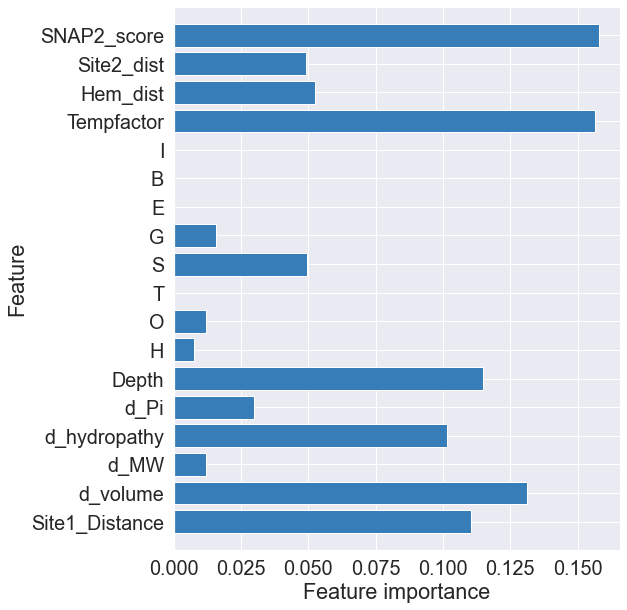

In [34]:
plot_feature_importances(tree_no_params)

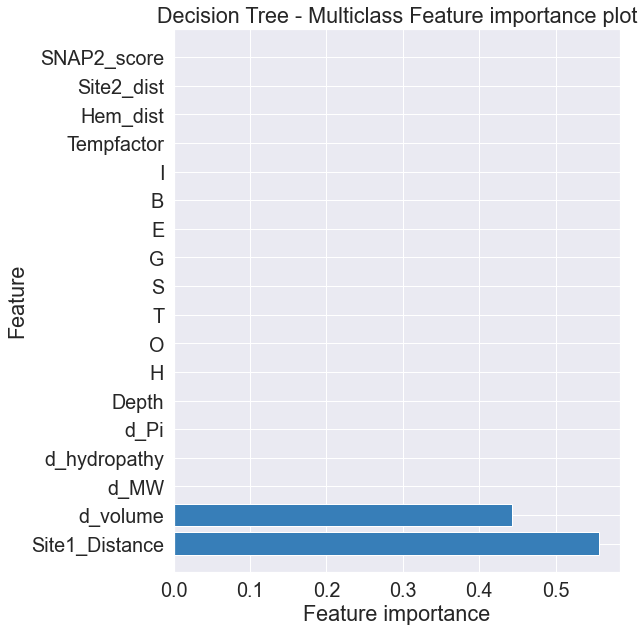

In [35]:
plot_feature_importances(tree_best_params)
plt.title('Decision Tree - Multiclass Feature importance plot')
plt.savefig('figures/direct_feature_coefficients_LSVC.png', bbox_inches='tight')

5. Produce confusion matrix with best parameters for ACCURACY

In [36]:
#copy and fit classifier with best parameters from previous section
tree = tree_best_params
tree.fit(X_train_cv, y_train_cv)                 
                 
predict = tree.predict(X_test_nodup)
#generate confusion matrix
target_names = ['<=0.025','0.05','0.1','0.2','0.4','0.8',  '1.6','>1.6']
confusion = confusion_matrix(y_test_nodup, predict, labels = target_names)

print ('\n multiclass confusion matrix: \n', confusion)


 multiclass confusion matrix: 
 [[ 0  6  0  0  0  0  0  2]
 [ 0  9  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  4]
 [ 0 10  0  0  0  0  0  3]
 [ 0  5  0  0  0  0  0  3]
 [ 0  3  0  0  0  0  0  5]
 [ 0  3  0  0  0  0  0  1]
 [ 0  7  0  0  0  0  0  6]]


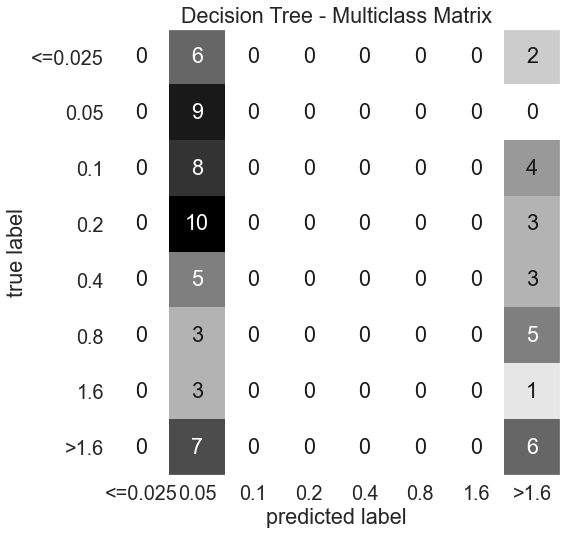

In [37]:
#generate heatmap of confusion matrix for visualisation

import mglearn

target_names = ['<=0.025','0.05','0.1','0.2','0.4','0.8',  '1.6','>1.6']
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('Decision Tree - Multiclass Matrix')
plt.gca().invert_yaxis()
plt.savefig('figures/indirect_multiclass_matrix_DT.png', bbox_inches='tight')

In [38]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.18      1.00      0.30         9
         0.1       1.00      0.00      0.00        12
         0.2       1.00      0.00      0.00        13
         0.4       1.00      0.00      0.00         8
         0.8       1.00      0.00      0.00         8
         1.6       1.00      0.00      0.00         4
     <=0.025       1.00      0.00      0.00         8
        >1.6       0.25      0.46      0.32        13

    accuracy                           0.20        75
   macro avg       0.80      0.18      0.08        75
weighted avg       0.77      0.20      0.09        75



6. Convert predicted MIC to binary phenotype

In [39]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {0:['0.2','0.4','0.8','1.6','>1.6'],
           1:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

7. Produce binary confusion matrix with best parameters for ACCURACY

Precision:  0.45098039215686275
Sensitivity:  0.7931034482758621
Specificity:  0.391304347826087
FPR : 0.6086956521739131
very major error : 60.86956521739131
major error:  20.689655172413794

 confusion matrix: 
 [[18 28]
 [ 6 23]]


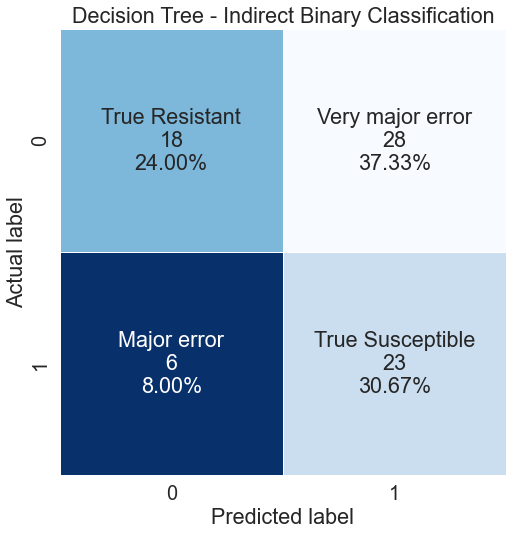

In [40]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))
cm = metrics.confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==0]))*100
major_error = (confusion[1][0]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==1]))*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Decision Tree - Indirect Binary Classification');
plt.savefig('figures/indirect_binary_matrix_DT.png', bbox_inches='tight')

#completes list of model quality values for model comparison
shifted_multiclass_VME = very_major_error
shifted_multiclass_ME = major_error

DT_quality = [direct_VME, direct_ME, shifted_direct_VME, shifted_direct_ME, \
              shifted_multiclass_VME,shifted_multiclass_ME]

DT_quality_df = pd.DataFrame({'DT_quality':DT_quality})
DT_quality_df.to_csv('DT_quality.csv')

In [41]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.75      0.39      0.51        46
           1       0.45      0.79      0.58        29

    accuracy                           0.55        75
   macro avg       0.60      0.59      0.54        75
weighted avg       0.63      0.55      0.54        75

